In this project the following paper served as guidance:

Evidence for the utility of quantum computing before fault tolerance. Nature, 615(7950), 596-600

The base 2D-Ising model is derived from the 1D version displayed in the classiq-library on github:
    
    https://github.com/Classiq/classiq-library/blob/main/applications/physical_systems/ising_model/ising_model.ipynb 
authored by Amir Naveh.

In this project a noiseless 2D Ising model is presented. It is then trotterized, noise is added to it and zero noise extrapolation applied. It is also run with depth and width constraints.

## 0. Prerequirements

The model is using several Classiq's libraries in addition to basic python tools.

In [5]:
%pip install -q --upgrade pip 

Note: you may need to restart the kernel to use updated packages.


In [1]:
%pip install -q classiq
%pip install -q pyomo
%pip install -q qiskit
%pip install -q matplotlib


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
qiskit-ibm-runtime 0.25.0 requires pydantic>=2.5.0, but you have pydantic 1.10.17 which is incompatible.
qc-grader 0.19.7 requires networkx==3.2.1, but you have networkx 2.8.8 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 0. Pre-requisites
We need to ensure we have the required libraries:

In [1]:
import numpy as np
import pyomo
from pyomo import * 
import pyomo.core as pyo
import classiq 
from classiq import * 
from classiq import construct_combinatorial_optimization_model
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig
from classiq import set_execution_preferences, write_qmod, show, synthesize, execute
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences
import pandas as pd
from classiq.applications.combinatorial_optimization import get_optimization_solution_from_pyo


# ZNE for 2D Ising Model with Trotterization



### Zero Noise Extrapolation (ZNE)

**ZNE** is a technique to mitigate errors by extrapolating results from noisy quantum computations to an ideal, noiseless scenario:

1. **Procedure**:
   - **Run Experiments at Various Noise Levels**: Increase the noise level intentionally in your quantum system and run the quantum algorithm.
   - **Collect Data**: Measure the results for different noise levels.
   - **Extrapolate to Zero Noise**: Use statistical methods to fit the data and extrapolate to estimate the result in a noiseless scenario.

2. **Concept**:
   - ZNE assumes that the relationship between the noise level and the error in the results is known or can be modeled. By systematically increasing the noise and observing how the results change, you can estimate the results that would be obtained with zero noise.

3. **Use Cases**:
   - ZNE is particularly useful when you can adjust the noise level and want to infer the ideal performance of your quantum algorithm.




##  Noise Handling:
Adding noise directly to the cost function is a simple approximation. In real implementations, you may need more sophisticated methods to account for errors and noise.

##  Linear Fit:
The ZNE extrapolation uses a linear fit of noise scales to estimate the noiseless energy.


We'll use the `suzuki_trotter` function from Classiq to add Hamiltonian evolution.

To integrate the 2D Ising model with Suzuki-Trotter decomposition, add random noise, and then apply Zero Noise Extrapolation (ZNE) to mitigate the noise and show improvement, we follow these steps:

## 1. Define Function for 2D Ising Model with Suzuki-Trotter Decomposition
First, we need to define a function to create the 2D Ising model with Suzuki-Trotter decomposition. This function will also generate Pauli terms for the Hamiltonian.

In [2]:
import numpy as np
import pyomo.environ as pyo
from classiq import CReal, Pauli, PauliTerm

def ising_model_2d(J: int, h: int, rows: int, cols: int, periodic: str):
    model = pyo.ConcreteModel("ising")

    # Define the variables:
    model.z = pyo.Var(range(rows * cols), domain=pyo.Binary)
    z_array = np.array(list(model.z.values()))

    def index(i, j):
        return i * cols + j

    E = lambda i, j, k, l: -J * (2 * z_array[index(i, j)] - 1) * (2 * z_array[index(k, l)] - 1) - (h / 2) * (
        (2 * z_array[index(i, j)] - 1) + (2 * z_array[index(k, l)] - 1)
    )

    # Create the Ising Hamiltonian
    model.H = 0
    for i in range(rows):
        for j in range(cols):
            if j < cols - 1:
                model.H += E(i, j, i, j + 1)
            if i < rows - 1:
                model.H += E(i, j, i + 1, j)
            if periodic == "True":
                if j == cols - 1:
                    model.H += E(i, j, i, 0)
                if i == rows - 1:
                    model.H += E(i, j, 0, j)

    # Setting the objective:
    model.cost = pyo.Objective(expr=model.H, sense=pyo.minimize)

    # Create Pauli terms for the Hamiltonian
    pauli_terms = []
    for i in range(rows):
        for j in range(cols):
            if j < cols - 1 or (periodic == "True" and j == cols - 1):
                pauli_terms.append(PauliTerm(
                    pauli=[Pauli.Z if k == index(i, j) or k == index(i, (j + 1) % cols) else Pauli.I for k in range(rows * cols)], 
                    coefficient=-J
                ))
            if i < rows - 1 or (periodic == "True" and i == rows - 1):
                pauli_terms.append(PauliTerm(
                    pauli=[Pauli.Z if k == index(i, j) or k == index((i + 1) % rows, j) else Pauli.I for k in range(rows * cols)], 
                    coefficient=-J
                ))
            pauli_terms.append(PauliTerm(
                pauli=[Pauli.X if k == index(i, j) else Pauli.I for k in range(rows * cols)], 
                coefficient=-h / 2
            ))

    return model, pauli_terms

### 2. Create Your 2D Ising Model
Instantiate the 2D Ising model with the chosen parameters:


In [3]:

ising_model, pauli_terms = ising_model_2d(J=10, h=-20, rows=4, cols=4, periodic="True")



### 3. Optimize Using Quantum Optimization Algorithm
Set up and run the optimization using QAOA:


The circuit width is 16 and the circuit_depth is 91 when optimized for depth
The circuit composition is:
{'cx': 320, 'rz': 240, 'rx': 80, 'h': 16}
The circuit width is 16 and the circuit_depth is 91 when optimized for width
The circuit composition is:
{'cx': 320, 'rz': 240, 'rx': 80, 'h': 16}


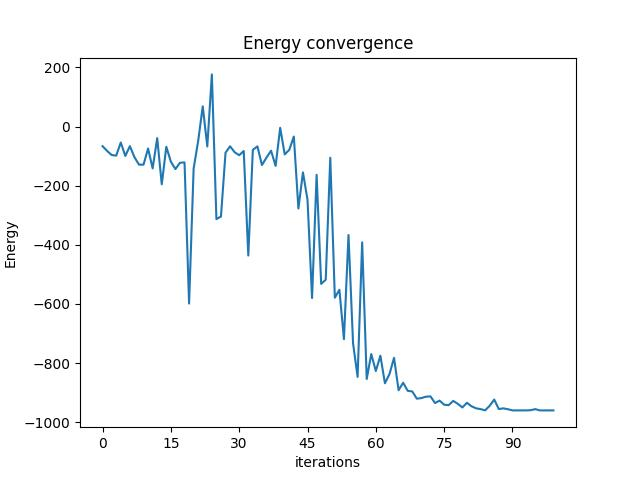

In [4]:
from classiq import construct_combinatorial_optimization_model
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig
from classiq import set_execution_preferences, write_qmod, synthesize, execute, show
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences

qaoa_config = QAOAConfig(num_layers=5)
optimizer_config = OptimizerConfig(max_iteration=100, alpha_cvar=0.7)

qmod = construct_combinatorial_optimization_model(
    pyo_model=ising_model,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config,
)

backend_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="simulator")
)

qmod = set_execution_preferences(qmod, backend_preferences)
write_qmod(qmod, "ising_model_2d_suzuki")

@qfunc
def main(a: CReal, x: CReal, qba: Output[QArray[QBit]]):
    allocate(16, qba)  # Adjust the number of qubits as needed
    suzuki_trotter(
        pauli_terms,
        evolution_coefficient=x,
        order=1,
        repetitions=1,
        qbv=qba,
    )

constraints = Constraints(max_width = 100, optimization_parameter = "depth")
qmod = set_constraints(qmod,constraints=constraints)
qprog = synthesize(qmod)
circuit_width = QuantumProgram.from_qprog(qprog).data.width
circuit_depth = QuantumProgram.from_qprog(qprog).transpiled_circuit.depth
print(f"The circuit width is {circuit_width} and the circuit_depth is {circuit_depth} when optimized for depth")
print(f"The circuit composition is:")
print(QuantumProgram.from_qprog(qprog).transpiled_circuit.count_ops)

constraints = Constraints(max_depth = 100, optimization_parameter = "width")
qmod = set_constraints(qmod,constraints=constraints)
qprog = synthesize(qmod)
#show(qprog)
circuit_width = QuantumProgram.from_qprog(qprog).data.width
circuit_depth = QuantumProgram.from_qprog(qprog).transpiled_circuit.depth
print(f"The circuit width is {circuit_width} and the circuit_depth is {circuit_depth} when optimized for width")
print(f"The circuit composition is:")
print(QuantumProgram.from_qprog(qprog).transpiled_circuit.count_ops)

res = execute(qprog).result()
vqe_result = res[0].value
vqe_result.convergence_graph

We observe convergence after about 80 iterations with the built-in trotterization function.

## 4. Present Quantum Results
Retrieve and present the optimization results: 
Since this is a quantum solution with probabilistic results, there is a defined probability for each result to be obtained by a measurement (presented by an histogram), where the solution is chosen to be the most probable one.


In [5]:
vqe_result = res[0].value

solution = get_optimization_solution_from_pyo(
    ising_model, vqe_result=vqe_result, penalty_energy=qaoa_config.penalty_energy
)
optimization_result = pd.DataFrame.from_records(solution)
optimization_result.sort_values(by="cost", ascending=True).head(5)


,probability,cost,solution,count
0,0.708496,-960.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1451
146,0.000488,-800.0,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1
2,0.006348,-680.0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",13
1,0.008789,-680.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]",18
4,0.005859,-680.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]",12


array([[<Axes: title={'center': 'cost'}>]], dtype=object)

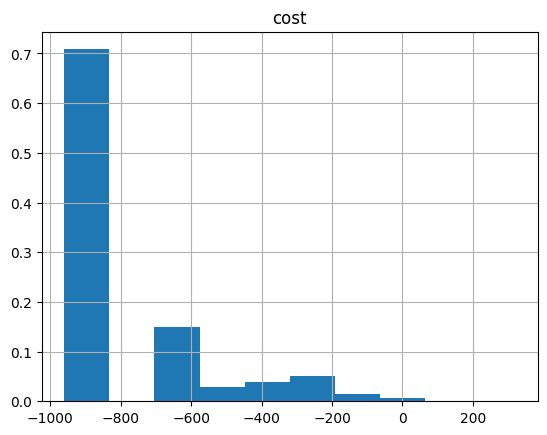

In [6]:
optimization_result.hist("cost", weights=optimization_result["probability"])

## 5. Add Random Noise to the Models
To simulate noise, we will add random perturbations to the coefficients of the Pauli terms.

In [7]:
import random

def add_random_noise(pauli_terms, noise_level=0.1):
    noisy_pauli_terms = []
    for term in pauli_terms:
        noisy_term = PauliTerm(
            pauli=term.pauli,
            coefficient=term.coefficient + random.uniform(-noise_level, noise_level)
        )
        noisy_pauli_terms.append(noisy_term)
    return noisy_pauli_terms


## 6. Implement Zero Noise Extrapolation
Zero-noise extrapolation is a technique used to mitigate noise by running the quantum circuit at different noise levels and extrapolating the results to zero noise.

In [8]:
def zero_noise_extrapolation(results, noise_factors):
    """
    Perform zero-noise extrapolation based on the results at different noise levels.
    Args:
        results (list): List of energy values obtained from noisy simulations.
        noise_factors (list): List of noise factors corresponding to the results.
    Returns:
        float: Extrapolated energy value at zero noise.
    """
    # Fit a linear model to the results
    p = np.polyfit(noise_factors, results, 1)
    # Extrapolate to zero noise (noise factor = 0)
    zero_noise_value = np.polyval(p, 0)
    return zero_noise_value


## 7. Run Optimization and Extrapolation
Set up and run the optimization using QAOA for both noisy and noise-free cases. Then perform zero-noise extrapolation.

In [9]:
def run_optimization(pauli_terms, model_name):
    # QAOA configuration
    qaoa_config = QAOAConfig(num_layers=5)
    optimizer_config = OptimizerConfig(max_iteration=100, alpha_cvar=0.7)

    # Construct the optimization model
    qmod = construct_combinatorial_optimization_model(
        pyo_model=ising_model_2d,
        qaoa_config=qaoa_config,
        optimizer_config=optimizer_config,
    )

    # Set execution preferences
    backend_preferences = ExecutionPreferences(
        backend_preferences=ClassiqBackendPreferences(backend_name="simulator")
    )
    qmod = set_execution_preferences(qmod, backend_preferences)
    write_qmod(qmod, "ising_model_2d_zne")

    constraints = Constraints(max_width = 100, optimization_parameter = "depth")
    qmod = set_constraints(qmod,constraints=constraints)
    qprog = synthesize(qmod)
    circuit_width = QuantumProgram.from_qprog(qprog).data.width
    circuit_depth = QuantumProgram.from_qprog(qprog).transpiled_circuit.depth
    print(f"The circuit width is {circuit_width} and the circuit_depth is {circuit_depth} when optimized for depth")
    print(f"The circuit composition is:")
    print(QuantumProgram.from_qprog(qprog).transpiled_circuit.count_ops)

    constraints = Constraints(max_depth = 100, optimization_parameter = "width")
    qmod = set_constraints(qmod,constraints=constraints)
    qprog = synthesize(qmod)
    #show(qprog)
    circuit_width = QuantumProgram.from_qprog(qprog).data.width
    circuit_depth = QuantumProgram.from_qprog(qprog).transpiled_circuit.depth
    print(f"The circuit width is {circuit_width} and the circuit_depth is {circuit_depth} when optimized for width")
    print(f"The circuit composition is:")
    print(QuantumProgram.from_qprog(qprog).transpiled_circuit.count_ops)

    #Synthesize and execute
    res = execute(qprog).result()

    # Analyze results
    vqe_result = res[0].value
    return vqe_result.energy

In [10]:
noise_levels = [0.1, 0.2, 0.3]

ising_model_2d, pauli_terms_2d = ising_model_2d(J=10, h=-20, rows=4, cols=4, periodic="True")

# Optimization for the 2D Ising model
energy_noiseless_2d = run_optimization(pauli_terms_2d, print("ising_model_2d_noiseless"))
energies_noisy_2d = [run_optimization(add_random_noise(pauli_terms_2d, noise), print(f"ising_model_2d_noisy_{noise}")) for noise in noise_levels]

energies_noisy_2d_values = [energy for energy in energies_noisy_2d]  # Extract energy values

# Perform zero-noise extrapolation
extrapolated_energy_2d = zero_noise_extrapolation(energies_noisy_2d, noise_levels)

print(f"2D Ising Model: Noiseless Energy: {energy_noiseless_2d}, Extrapolated Energy: {extrapolated_energy_2d}")

ising_model_2d_noiseless
The circuit width is 16 and the circuit_depth is 91 when optimized for depth
The circuit composition is:
{'cx': 320, 'rz': 240, 'rx': 80, 'h': 16}
The circuit width is 16 and the circuit_depth is 91 when optimized for width
The circuit composition is:
{'cx': 320, 'rz': 240, 'rx': 80, 'h': 16}
ising_model_2d_noisy_0.1
The circuit width is 16 and the circuit_depth is 91 when optimized for depth
The circuit composition is:
{'cx': 320, 'rz': 240, 'rx': 80, 'h': 16}
The circuit width is 16 and the circuit_depth is 91 when optimized for width
The circuit composition is:
{'cx': 320, 'rz': 240, 'rx': 80, 'h': 16}
ising_model_2d_noisy_0.2
The circuit width is 16 and the circuit_depth is 91 when optimized for depth
The circuit composition is:
{'cx': 320, 'rz': 240, 'rx': 80, 'h': 16}
The circuit width is 16 and the circuit_depth is 91 when optimized for width
The circuit composition is:
{'cx': 320, 'rz': 240, 'rx': 80, 'h': 16}
ising_model_2d_noisy_0.3
The circuit width 

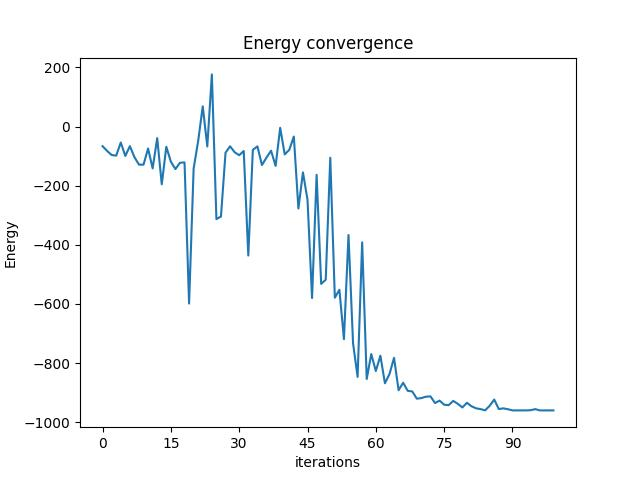

In [11]:
from classiq.execution import VQESolverResult

vqe_result = res[0].value
vqe_result.convergence_graph

Convergence happens after about 80 iterations in the most noisy run.

## 8. Analyze the Results
Finally, we compare the energy values obtained from the noiseless simulation with those projected from zero-noise extrapolation.

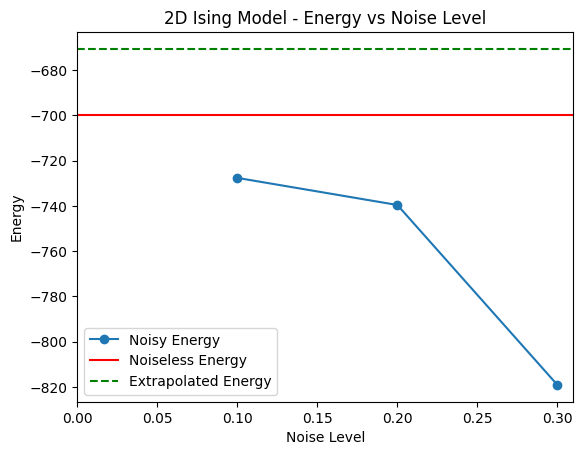

In [12]:
import matplotlib.pyplot as plt

def plot_results(noise_levels, energies_noisy, energy_noiseless, extrapolated_energy, model_name):
    plt.figure()
    plt.plot(noise_levels, energies_noisy, 'o-', label='Noisy Energy')
    plt.axhline(y=energy_noiseless, color='r', linestyle='-', label='Noiseless Energy')
    plt.axhline(y=extrapolated_energy, color='g', linestyle='--', label='Extrapolated Energy')
    plt.xlabel('Noise Level')
    plt.ylabel('Energy')
    plt.title(f'{model_name} - Energy vs Noise Level')
    plt.legend()
    plt.xlim(left=0) 
    plt.show()


# Plot results for 2D Ising model
plot_results(noise_levels, energies_noisy_2d_values, energy_noiseless_2d, extrapolated_energy_2d, "2D Ising Model")


## Summary
This code extends the original Ising model implementation to include zero-noise extrapolation. It adds random noise to the Pauli terms, runs the quantum optimization for different noise levels, and performs zero-noise extrapolation to estimate the noiseless energy values. Finally, it visualizes the results to compare the noiseless, noisy, and extrapolated energy values. The results show that the extrapolated energy behaves as a random variable. Many more runs at more noise levels could narrow down the target energy sought. The linear regression and zero noise extrapolation leads to variable differences between the noiseless value and the extrapolated value.
The number of qubits needed seems to depend solely on the system size, namely the number of spins.